In [41]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import geopandas as gp
from datetime import timedelta
from collections import namedtuple
from sbbarrivals import plot_train_station_stats
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Introduction 

This notebook analyzes the daily delays of SBB trains and creates a visualization of the average delay at each train station.

Note that the underlying data contains only train stations served by SBB. Other local train lines are not in the dataset.

# 2 Import and clean datasets

Two publicly available datasets are required:

* Actual and predicted arrival and departures of SBB trains (source: https://data.sbb.ch/explore/dataset/ist-daten-sbb)
* Circumference of Switzerland (source: https://data.geo.admin.ch/ch.swisstopo.swissboundaries3d)

## 2. 1 Train arrivals and departures
Import train data either from a local file or the latest dataset of the previous day from the SBB API.

In [48]:
filename = "actual-data-sbb-previous-day.json"

if os.path.exists(filename):
    # Fetch the local dataset
    source = filename
else:
    # Fetch the latest data from SBB (note: with online data, some notebook text might be invalid)
    source = "https://data.sbb.ch/api/v2/catalog/datasets/actual-data-sbb-previous-day/exports/json"

# Citation of data
datasource = "https://data.sbb.ch/explore/dataset/ist-daten-sbb"

df = pd.read_json(
    source,
    convert_dates=["an_prognose", "ab_prognose", "abfahrtszeit", "ankunftszeit"]
)

In [49]:
# Timestamp of the dataset
betriebstag = df.betriebstag.unique()[0]
print(f"Betriebstag:\t{betriebstag}")

Betriebstag:	2023-01-12


In [50]:
df.head()

betriebstag fahrt_bezeichner betreiber_id betreiber_abk  \
0  2023-01-12  85:11:19219:001        85:11           SBB   
1  2023-01-12  85:11:19219:001        85:11           SBB   
2  2023-01-12  85:11:19219:001        85:11           SBB   
3  2023-01-12  85:11:19219:001        85:11           SBB   
4  2023-01-12  85:11:19219:001        85:11           SBB   

                    betreiber_name produkt_id  linien_id linien_text  \
0  Schweizerische Bundesbahnen SBB        Zug      19219         S12   
1  Schweizerische Bundesbahnen SBB        Zug      19219         S12   
2  Schweizerische Bundesbahnen SBB        Zug      19219         S12   
3  Schweizerische Bundesbahnen SBB        Zug      19219         S12   
4  Schweizerische Bundesbahnen SBB        Zug      19219         S12   

   umlauf_id verkehrsmittel_text  ... ankunftsverspatung abfahrtsverspatung  \
0        NaN                   S  ...              false              false   
1        NaN                   S  ...              false              false   
2        NaN                   S  ...              false              false   
3        NaN                   S  ...              false              false   
4        NaN                   S  ...              false              false   

    didok bezeichnung_offiziell abkuerzung  \
0  3003.0    Zürich Stadelhofen       ZSTH   
1  6000.0            Winterthur          W   
2  6035.0            Schottikon       SCHK   
3  6012.0         Guntershausen        GUN   
4  6206.0                Wil SG        WIL   

                                                lod  \
0  http://lod.opentransportdata.swiss/didok/8503003   
1  http://lod.opentransportdata.swiss/didok/8506000   
2  http://lod.opentransportdata.swiss/didok/8506035   
3  http://lod.opentransportdata.swiss/didok/8506012   
4  http://lod.opentransportdata.swiss/didok/8506206   

                                              geopos tu_nummer  \
0  {'lon': 8.548489088449454, 'lat': 47.366609766...      11.0   
1  {'lon': 8.72382105540869, 'lat': 47.5003338104...      11.0   
2  {'lon': 8.811719072425081, 'lat': 47.500117498...      11.0   
3  {'lon': 8.917032104095119, 'lat': 47.474121355...      11.0   
4  {'lon': 9.040993050468307, 'lat': 47.462413242...      11.0   

                                 meteo     plz  
0  https://meteo.sbb.ch/?didok=8503003  8001.0  
1  https://meteo.sbb.ch/?didok=8506000  8400.0  
2  https://meteo.sbb.ch/?didok=8506035  8352.0  
3  https://meteo.sbb.ch/?didok=8506012  8357.0  
4  https://meteo.sbb.ch/?didok=8506206  9500.0  

[5 rows x 31 columns]

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63102 entries, 0 to 63101
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   betriebstag            63102 non-null  object        
 1   fahrt_bezeichner       63102 non-null  object        
 2   betreiber_id           63102 non-null  object        
 3   betreiber_abk          63102 non-null  object        
 4   betreiber_name         63102 non-null  object        
 5   produkt_id             63048 non-null  object        
 6   linien_id              63102 non-null  int64         
 7   linien_text            63102 non-null  object        
 8   umlauf_id              0 non-null      float64       
 9   verkehrsmittel_text    63102 non-null  object        
 10  zusatzfahrt_tf         63102 non-null  object        
 11  faellt_aus_tf          63102 non-null  object        
 12  bpuic                  63102 non-null  int64         
 13  h

Some columns such as 
        `betriebstag`,
        `betreiber_name`,
        `umlauf_id`, 
        `meteo`, 
        `didok`, 
        `lod`, 
        `verkehrsmittel_text`,
        `abkuerzung`, 
        `durchfahrt_tf`, 
        `betreiber_abk`, 
        `betreiber_id`, 
        `linien_id`,
        `linien_text`,
        `bpuic`,
        `produkt_id`,
        `plz`,
        `tu_nummer` and
        `zusatzsfahrt_tf`
are irrelevant for this analysis, so let's remove them.

This analysis focuses on delays on arrival, so `ab_prognose` and `ab_prognose_status` can be removed too. And `bezeichnung_offiziell` is a duplicate of `haltestellen_name`.

In [52]:
# Remove empty and irrelevant columns
columns = [
        "betriebstag",
        "betreiber_name",
        "umlauf_id", 
        "meteo", 
        "didok", 
        "lod", 
        "verkehrsmittel_text",
        "abkuerzung", 
        "durchfahrt_tf", 
        "betreiber_abk", 
        "betreiber_id", 
        "linien_id",
        "linien_text",
        "bpuic",
        "produkt_id",
        "plz",
        "tu_nummer",
        "zusatzfahrt_tf",
        "ab_prognose",
        "ab_prognose_status",    
        "bezeichnung_offiziell"
    ]

df = df.drop(columns, axis=1, errors="ignore")

Transform the dictionary with the station coordinates into two columns:

In [53]:
df["lat"] = df.geopos.apply(lambda s: s["lat"] if s is not None else None)
df["lon"] = df.geopos.apply(lambda s: s["lon"] if s is not None else None)

df = df.drop("geopos", axis=1)

Create Python booleans from the text false/true values

In [54]:
columns = ["ankunftsverspatung", "faellt_aus_tf"]

df[columns] = df[columns].replace({"true": True, "false": False})

## 2.2 Import geo data

In [55]:
from sbbarrivals import get_zip_content

url = "https://data.geo.admin.ch/ch.swisstopo.swissboundaries3d/swissboundaries3d_2022-01/swissboundaries3d_2022-01_2056_5728.gdb.zip"

# Download and unpack gdb file
root, *_ = get_zip_content(url)
gdf = gp.read_file(root)

In [56]:
# Check out the content
gdf

UUID           DATUM_AENDERUNG  \
0  {B347A0FB-1DB1-42CE-8F76-D95FD4786266} 2020-11-18 10:27:49+00:00   
1  {CB779724-7723-43D5-A5E8-28A160F9E17C} 2020-11-20 10:41:17+00:00   
2  {E3B673E2-0742-4EEF-AA36-1E2AFC76E457} 2020-11-18 10:27:41+00:00   
3  {822DD488-9754-4EE2-8040-8C146793B84F} 2020-11-18 10:27:44+00:00   

           DATUM_ERSTELLUNG  ERSTELLUNG_JAHR  ERSTELLUNG_MONAT  REVISION_JAHR  \
0 2012-10-26 12:21:24+00:00             2012                10           2022   
1 2012-10-26 12:21:26+00:00             2012                10           2022   
2 2012-10-26 12:21:26+00:00             2012                10           2022   
3 2012-10-26 12:21:26+00:00             2012                10           2022   

   REVISION_MONAT  GRUND_AENDERUNG  HERKUNFT  HERKUNFT_JAHR  ...  SEE_FLAECHE  \
0               1              400       500           2020  ...     129858.0   
1               1              400       500           2020  ...          NaN   
2               1              400       500           2020  ...          NaN   
3               1              400       500           2020  ...        172.0   

   ICC  REVISION_QUALITAET LANDESFLAECHE LAND_TEIL           NAME  \
0   CH         2021_Aufbau     4129068.0         0        Schweiz   
1   LI         2021_Aufbau       16048.0         0  Liechtenstein   
2   DE         2021_Aufbau         763.0         0    Deutschland   
3   IT         2021_Aufbau         264.0         0         Italia   

   EINWOHNERZAHL  Shape_Length    Shape_Area  \
0        8670300  1.970562e+06  4.129068e+10   
1          39062  7.793831e+04  1.604767e+08   
2           1519  1.699871e+04  7.631692e+06   
3           2003  7.188926e+03  2.643791e+06   

                                            geometry  
0  MULTIPOLYGON Z (((2517562.488 1140182.311 372....  
1  MULTIPOLYGON Z (((2762176.352 1229345.626 1605...  
2  MULTIPOLYGON Z (((2694854.441 1283124.821 390....  
3  MULTIPOLYGON Z (((2718599.703 1091193.657 286....  

[4 rows x 22 columns]

<AxesSubplot:>

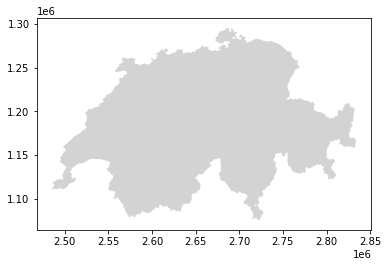

In [57]:
# Get the swiss boundaries
swiss = gdf[gdf.NAME == "Schweiz"]
swiss.plot(fc="lightgray")

In [58]:
# Transform the coordinates from EPSG:2056 to EPSG:4326 to be compatible with lat/lon of the train data
swiss = swiss.to_crs("EPSG:4326")
swiss.plot(fc="lightgray")

<AxesSubplot:>

# 3 Exploratory analysis
## 3.1 Evaluation of the delays

Compute the cumulated (or average) delay of the trains entering a certain train station within a given time span.

* The cumulated delay as a measure accounts better for large delays of one or multiple trains in a train station
* The average delay is more appropriate to express how late on average the passengers will be arriving

We see that 95% of trains are on time, when we use the `ankunftsverspatung` variable of the dataset.

In [59]:
df.ankunftsverspatung.value_counts(normalize=True)

False    0.948655
True     0.051345
Name: ankunftsverspatung, dtype: float64

Since we only analyze delays on arrival at train stations, we have to further clean the dataset from missing values in the variables `bezeichnung_offiziell`, `ankunftszeit`, `an_prognose`.

In [60]:
# Remove empty rows
df.dropna(subset=["haltestellen_name", "ankunftszeit", "an_prognose"], inplace=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57674 entries, 0 to 63101
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fahrt_bezeichner    57674 non-null  object        
 1   faellt_aus_tf       57674 non-null  bool          
 2   haltestellen_name   57674 non-null  object        
 3   ankunftszeit        57674 non-null  datetime64[ns]
 4   an_prognose         57674 non-null  datetime64[ns]
 5   an_prognose_status  57674 non-null  object        
 6   abfahrtszeit        52555 non-null  datetime64[ns]
 7   ankunftsverspatung  57674 non-null  bool          
 8   abfahrtsverspatung  57674 non-null  object        
 9   lat                 57520 non-null  float64       
 10  lon                 57520 non-null  float64       
dtypes: bool(2), datetime64[ns](3), float64(2), object(4)
memory usage: 4.5+ MB


We create time bins of 15 minutes where delays are aggregated; a quarter hour captures trains that arrive around the full or half hour in major train stations. Yet it limits the number of images of the visualization.  

In [62]:
df["time_bin"] = df.an_prognose.dt.floor(timedelta(seconds=900))

Compute the delay of arrival as the difference between actual and expected time of arrival.

In [63]:
# Feature an_verspatung_dt
df["an_verspatung_dt"] = df.an_prognose - df.ankunftszeit
df["an_verspatung_m"] = df.an_verspatung_dt.dt.total_seconds() / 60

Get a glimps of the deviations of the arrival time from the scheduled arrival.. More than 94% of the trains arrive on time at the train station.

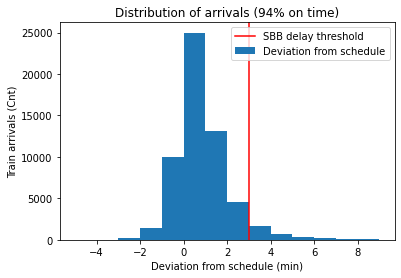

In [64]:
ax = df.plot(
    y="an_verspatung_m", 
    kind="hist", 
    bins=range(-5, 10, 1), 
    label="Deviation from schedule",
)

ax.axvline(3, c="r", label="SBB delay threshold")
ontime_pct = sum(df.an_verspatung_m <= 3) / len(df) * 100

ax.set_xlabel("Deviation from schedule (min)")
ax.set_ylabel("Train arrivals (Cnt)")
ax.set_title(f"Distribution of arrivals ({ontime_pct:.0f}% on time)")
ax.legend()

This statistics aligns with the feature `ankunftsverspatung` in the original dataset.

In [65]:
print(f"{'(1-AVG(ankunftsverpatung)) * 100:':<35}\t{100 - sum(df.ankunftsverspatung) / len(df) * 100:.3}%")
print(f"{'Arrivals with 3 min or less delay:':<35}\t{ontime_pct:.3}%")

(1-AVG(ankunftsverpatung)) * 100:  	94.4%
Arrivals with 3 min or less delay: 	94.4%


We are only interested in delays we set early arrivals to zero.

In [66]:
# df["an_verspatung_m"] = df["an_verspatung_m"].where(df.an_verspatung_m >= 0, 0)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57674 entries, 0 to 63101
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   fahrt_bezeichner    57674 non-null  object         
 1   faellt_aus_tf       57674 non-null  bool           
 2   haltestellen_name   57674 non-null  object         
 3   ankunftszeit        57674 non-null  datetime64[ns] 
 4   an_prognose         57674 non-null  datetime64[ns] 
 5   an_prognose_status  57674 non-null  object         
 6   abfahrtszeit        52555 non-null  datetime64[ns] 
 7   ankunftsverspatung  57674 non-null  bool           
 8   abfahrtsverspatung  57674 non-null  object         
 9   lat                 57520 non-null  float64        
 10  lon                 57520 non-null  float64        
 11  time_bin            57674 non-null  datetime64[ns] 
 12  an_verspatung_dt    57674 non-null  timedelta64[ns]
 13  an_verspatung_m     57674 non-n

There are around 45900 datapoints left in the dataset. 

## 3.2 Key statistics of the dataset

It seems that Zurich HB has the highest cumulated delay over the entire day, followed by Basel SBB. This is reasonable since they are rather large train stations with many connections.

In [68]:
cum_delay = df.groupby("haltestellen_name").an_verspatung_m.sum().sort_values(ascending=False)
cum_delay.head(10)

haltestellen_name
Zürich HB             1438.716667
Basel SBB              918.400000
Zürich Oerlikon        810.400000
Zürich Hardbrücke      636.733333
Olten                  484.783333
Zürich Flughafen       419.233333
Zürich Stadelhofen     397.950000
Basel Bad Bf           383.000000
Winterthur             379.583333
Solothurn              339.300000
Name: an_verspatung_m, dtype: float64

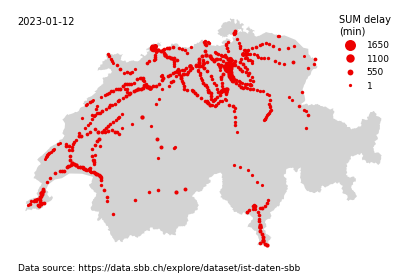

In [69]:
fig, ax = plot_train_station_stats(
    df.groupby(["haltestellen_name", "lat", "lon"]).an_verspatung_m.sum(), 
    gmap=swiss,
    datasource=f"Data source: {datasource}",
    timestamp=betriebstag,
    legend_title="SUM delay\n(min)",
    legend_values=[1, 550, 1100, 1650],
    legend_lims=[3, 10],
    color="#ec0000",
)

In terms of average delay, the delay normalized by the number of connections, a different view presents itself. 

In [70]:
avg_delay = df.groupby(["haltestellen_name", "lat", "lon"]).an_verspatung_m.mean().sort_values(ascending=False)
avg_delay.head(10)

haltestellen_name   lat        lon     
Basel Bad Bf        47.567308  7.606920    6.491525
Gerra (Gambarogno)  46.122041  8.784970    4.372917
S. Nazzaro          46.135158  8.807059    3.782292
Ranzo-S. Abbondio   46.116998  8.776538    3.517778
Flamatt             46.888491  7.319571    3.408333
Henniez             46.735001  6.870106    3.152083
Basel St. Johann    47.570306  7.572529    3.128623
Wynigen             47.105175  7.663507    2.950000
Crémines-Zoo        47.272420  7.456784    2.732883
Corcelles BE        47.285665  7.450463    2.695946
Name: an_verspatung_m, dtype: float64

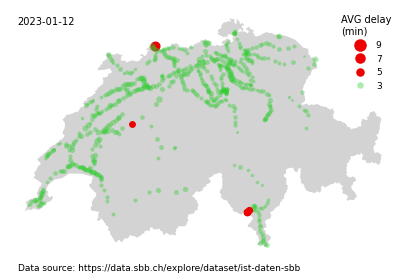

In [71]:
from sbbarrivals import plot_train_station_stats, colormap


fig, ax = plot_train_station_stats(
    df.groupby(["haltestellen_name", "lat", "lon"]).an_verspatung_m.mean(),
    gmap=swiss,
    datasource=f"Data source: {datasource}",
    timestamp=betriebstag,
    legend_title="AVG delay\n(min)",
    legend_values=[3, 5, 7, 9],
    legend_lims=[2, 10],
    color="#ec0000",
    cmap=colormap("limegreen", "#ec0000", int(3 / 6 * 200), 200)
)

It is interesting to note that the relative delays are often large at train stations close to the border. This is aligns with personal experience for trains from south- and eastbound connections. Is this pure chance or is there a significant effect?

In [72]:
# Grenzbahnhöfe
# Data source: https://map.geo.admin.ch
border_stations = [
    "Basel Bad Bhf",
    "Schaffhausen",
    "Genève",
    "Chiasso",
    "Buchs SG",
    "Stabio",
    "Kreuzlingen",
    "Hafen",
    "Thayngen",
    "Rafz",
    "Koblenz",
    "Boncourt",
    "Travers",
    "Vallorbe",
    "La Plaine",
    "Chêne-Bourg",
    "Brig",
    "Gerra (Gambarogno)"
]
df["grenzbahnhof"] = df.haltestellen_name.isin(border_stations)

In [73]:
df.groupby("grenzbahnhof").an_verspatung_m.agg(["mean", "std"])

mean       std
grenzbahnhof                    
False         0.919005  1.720916
True          0.732216  3.193758

In [91]:
fig, ax = plt.subplots()
df.groupby("grenzbahnhof").plot(y="an_verspatung_m", kind="density", bw_method=0.1, ax=ax, ind=np.arange(-10, 10, 0.1))
plt.xlabel("Verspätung (minutes)")
plt.legend(["False", "True"], title="Grenzbahnhof")

We assume that there is no difference in the average delay between stations that are close to border stations and those that are further away from train stations. To test this we assume further that the delays are normally distributed but with unequal distribution and perform a Welch t-test.

The null hypothesis is that 

$H_0: \mu_{border} = \mu_{inside}$

and the alternative hypothesis is 

$H_1: \mu_{border} \neq \mu_{inside}$

We choose a significance level $\alpha=0.05$

$P(-c<=t<=c) = 1-0.05*2 = 0.99$

In [113]:
from scipy.stats import ttest_ind

# t-test for the means of two independent samples with unequal population variance
t = ttest_ind(x1, x2, equal_var=False).statistic
print(f"t={t:0.3f}")

t=-2.228


In [112]:
print(f"P(-2.576<=-2.228<=2.576) = 0.99")

P(-2.576<=-2.228<=2.576) = 0.99


Under the given observations we cannot reject the null hypothesis that the in-bound trains have an equal average delay than the out-bound.

## 3.3 Trains that could catch up their delay

Another intersting question is: "How many trains could catch up their delay to arrive on time at their final destination?"

The `fahrt_bezeichner` can be used to identify the chronology of train stations visited by the train.
For each ride we can evaluate if the train was once delayed and if he was on time at the last train station.

In [29]:
# Rides
rides = df.sort_values("abfahrtszeit").groupby("fahrt_bezeichner")

# Evaluate if train was delayed and if it arrive on time
timing = rides.agg(
    delayed=pd.NamedAgg("abfahrtsverspatung", lambda s: s.any()),
    arrived_on_time=pd.NamedAgg("ankunftsverspatung", lambda s: s.iloc[-1] == False)
)

# Summarize over all rides
timing_cnts = timing.value_counts().sort_index()
timing_cnts

delayed  arrived_on_time
True     False               375
         True               5147
dtype: int64

In [30]:
behind_schedule = timing_cnts[(True,)].sum()
on_time = timing_cnts[(True, True)]
print(f"{on_time / behind_schedule *100:.1f}% of trains could catch up their delay.")

93.2% of trains could catch up their delay.


# 3 Animations
## 3.1 Delays throughout the day

A benefit of a dynamic analysis is that disturbances in the train network can be observed over time. To highlight the delays the maximum delay at a specific train station is chosen as a metric. The delays of all trains at every train station are aggregated into time bins of 15 minutes. 

The graphic then visualizes for every train station the maximum delay that occured within 15 minutes.

In [31]:
# A timeseries with delay time per train station
delay = df.pivot_table(
    index="time_bin",
    columns=["haltestellen_name", "lat", "lon"], 
    values="an_verspatung_m", 
    aggfunc="max"
)

In [36]:
# Are there any NaNs?
delay.isnull().any(axis=None)

True

Some datapoints are empty because not every train station is visited by a train within the 15 minutes time frame. We set NaN values to 0; they have no delay. 

For visuals, a mean filtering is performed that reduces abrupt changes of the color and marker size.

In [37]:
delay = delay.fillna(0).rolling(window="0.5H", center=True).mean()

In order to visualize the delays throughout the day we create a plot for every 15 minutes and compile a video from the images. (This process might take a while)

In [32]:
%%capture
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from datetime import datetime
from tqdm import tqdm
from matplotlib.colors import ListedColormap, to_rgb
import numpy as np

counter = 0
for time, stations in tqdm(list(delay.iterrows())):
    
    fig, ax = plot_train_station_stats(
        stations, 
        gmap=swiss,
        datasource=f"Data source: {datasource}",
        timestamp=time,
        legend_title="MAX delay\n(min)",
        legend_values=[3, 10, 20, 30, 40],
        legend_lims=[2, 10],
        color="#ec0000",
        text_color = "k",
        gmap_color = "lightgray",
        value_range=[0, 45],
        cmap=colormap("limegreen", "#ec0000", int(3 / 30 * 200), 200)
    )

    fig.savefig(f"img/sbb_{counter:03d}.png", dpi=96)
    counter += 1
    plt.close(fig)

Finally the pictures are aggregated into a `mp4` container.

In [33]:
import ffmpeg
import os

if os.path.exists("sbb-delay.mp4"):
    os.remove("sbb-delay.mp4")

ffmpeg\
    .input("img/sbb_%03d.png", framerate=6)\
    .output(
        "sbb-delay.mp4",
        **{"s:v": "1024x910", "c:v":"libx264", "profile:v": "high", "crf": 20, "pix_fmt": "yuv420p"},
    )\
    .run()

(None, None)